1.Import Dependencies and Data

In [2]:
!pip install tensorflow tensorflow-gpu tensorflow-datasets ipywidgets matplotlib

^C


In [1]:
#Bringing in tensoflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
gpus

[]

In [3]:
#Bringing in tensorflow datasets api to bring in the data source
import tensorflow_datasets as tfds
#Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

In [4]:
#Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\elbou\tensorflow_datasets\fashion_mnist\3.0.1.incompleteII4OTT\fashion_mnist-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\elbou\tensorflow_datasets\fashion_mnist\3.0.1.incompleteII4OTT\fashion_mnist-test.tfrecord*…

Dataset fashion_mnist downloaded and prepared to C:\Users\elbou\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


2. Viz Data and Build Dataset

In [5]:
#Do some data transforming 
import numpy as np

In [6]:
#Setup the iterator
dataiterator = ds.as_numpy_iterator()

In [8]:
#Getting data out of the pipeline
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 59],
        [ 77],
        [ 58],
        [ 56],
        [ 58],
        [ 57],
        [ 65],
        [ 89],
        [  2],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [245],
        [213],
        [199],
        [192],
        [188],
        [189],
        [184],
        [226],
        [ 90],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [101],
      

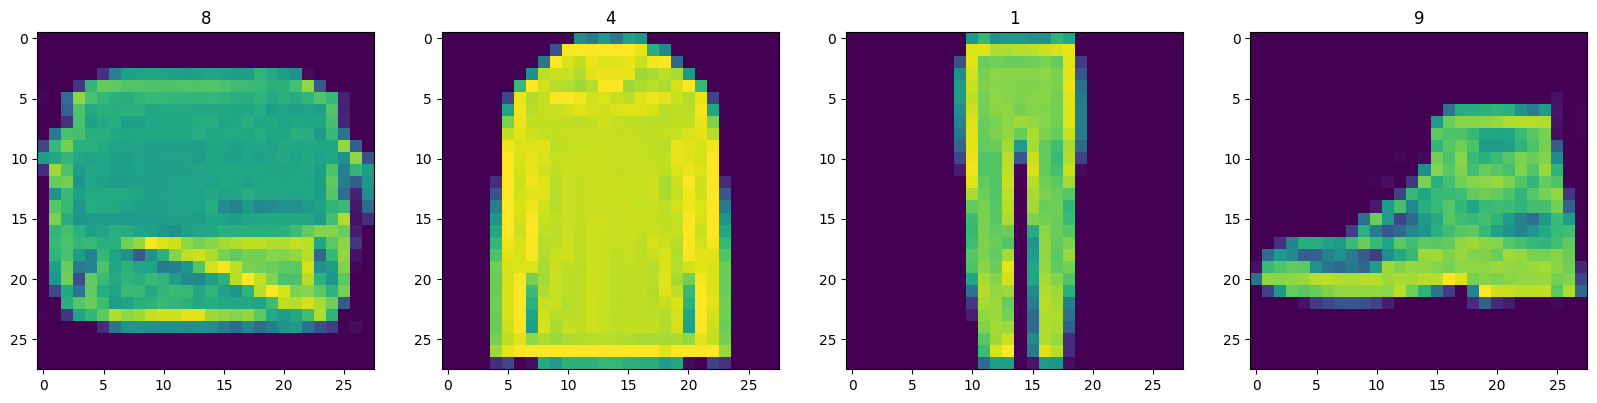

In [9]:
#Setup the subplots formatting
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
#Loop four times and get images
for idx in range(4):
    #Grab an image and label
    sample = dataiterator.next()
    #Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(sample['image']))
    #Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [15]:
#Scale images
def scale_images(data):
    image = data['image']
    return image / 255

In [16]:
#Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
#Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
#Cache the dataset for that batch
ds = ds.cache()
#Shuffle it up
ds = ds.shuffle(60_000)
#Batch into 128 images per fetch
ds = ds.batch(128)
#Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

3. Build GANs

3.1 Import Modeling Components

In [49]:
#Bring in the sequential api for the generator and discriminator 
from tensorflow.keras.models import Sequential
#Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [50]:
def build_generator():
    model = Sequential()
    
    #Takes in random values and reshapes it to 7x7x128
    #Beginnigs of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    #Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    #Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    #Convolution block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    #Convolution block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    #Conv layer to get the one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [51]:
generator = build_generator()

In [52]:
generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_3 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 175ms/step


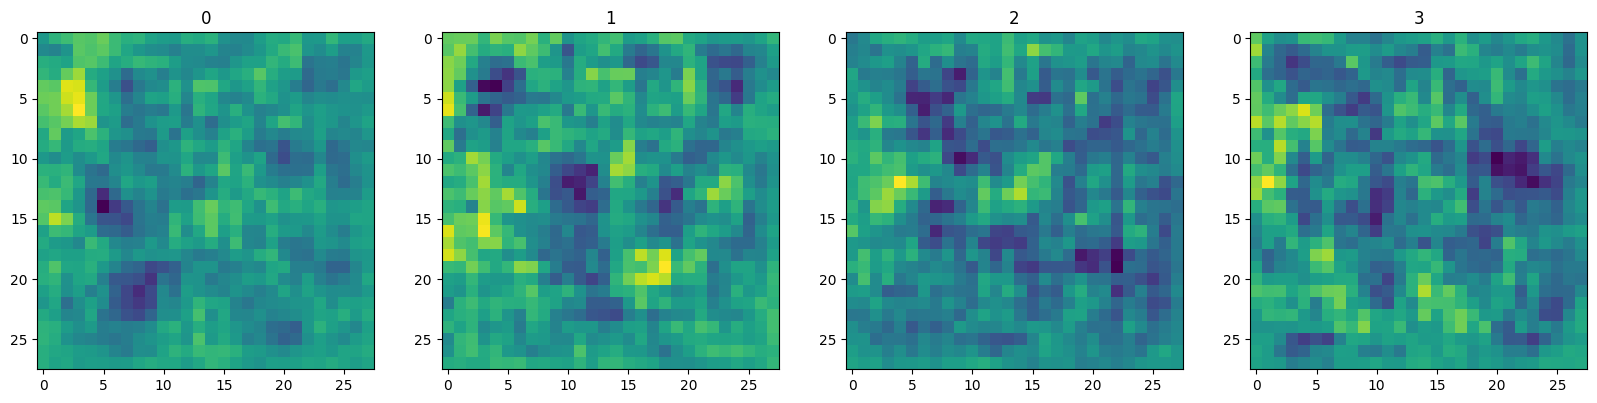

In [53]:
#genrate new fashion
imgs = generator.predict(np.random.randn(4, 128, 1))
#Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
#loop four times and get images
for idx, img in enumerate(imgs):
    #Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    #Appending the image label as the plot title
    ax[idx].title.set_text(idx)

In [54]:
def build_discriminator():
    model = Sequential()
    
    #First Conv Block
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    #Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Flattern then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [55]:
discriminator = build_discriminator()

discriminator.summary()

In [56]:
discriminator.predict(imgs)

1/1 [==============================] - 0s 105ms/step


array([[0.4986371 ],
       [0.49859425],
       [0.49841014],
       [0.49858344]], dtype=float32)

4. Construct the Trainig Loop

4.1 Setup Losses and Optimizers

In [57]:
#importing the Adam optimizer
from tensorflow.keras.optimizers import Adam
#importing cross entropy loss function
from tensorflow.keras.losses import BinaryCrossentropy

In [58]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

4.2 Build Subclassed Model

In [59]:
#Importing the base model class to subclass our training 
from tensorflow.keras.models import Model


In [60]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        #Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        
        #Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        #Compile with base class
        super().compile(*args, **kwargs)
        
        #Create attributes for losses and optimizers
        self.g_opt = g_opt 
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
    
    def train_step(self, batch):
        #Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        #Train the discriminator
        with tf.GradientTape() as d_tape:
            #Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            #Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            #Add dome noise to the outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            #Calulate loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
        
        #Apply backpropagation -nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        #Train the generator
        with tf.GradientTape() as g_tape:
            #Generate some new images
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)
            
            #Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
            
            #Calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
        
        #Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [61]:
#Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [62]:
#Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

4.3 Build Callback

In [63]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [64]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim 
    
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

4.3 Train

In [68]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
  6/469 [..............................] - ETA: 1:17:23 - d_loss: 0.6929 - g_loss: 0.6926

KeyboardInterrupt: 

4.4 Review Performance

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

5.1 Generate Images

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])